# Prediction Chest Diagnostics with X-Rays
### Summary:
The NIH has recently made open source over **Xthousands** labeled images of X-ray's with different features such as the patients age, gender, and the finding from the image. In this module we use transfer learning using MobileNet as a backbone architecture and train with additional CNNs to see if we can 
Our module consists of **6 steps:**
1. Loading the Data
2. Cleaning the Data
3. Augmenting/reproducing the Data (with ImageDataGenerator)
4. Creating the Keras DeepLearning Model
5. Evaluate the performance

## 0. Options to Increase accuracy (potentially), decrease learning time
Adjust these options to change the potential training time/accuracy of the model.

In [174]:
IMG_SIZE = (128,128)

In [175]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from glob import glob

# For the Model
from keras.preprocessing.image import ImageDataGenerator
from itertools import chain
from keras.callbacks import ModelCheckpoint, EarlyStopping

## 1. Load the Data
### 1.1 Read the Excel Data sheet

In [209]:
meta_data = pd.read_csv('./Data_Entry_2017.csv')
meta_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### 1.2 Add a Column for the path to the image

In [210]:
all_image_paths = {os.path.basename(x): x for x in  glob(os.path.join('.', 'data', 'images *',  '*.png'))}
meta_data['file_location'] = meta_data['Image Index'].map(all_image_paths.get)

### 1.3  Remove any row that we did not find a image path to
Due to limited storage space on my mac, I was able to retrieve and train/test on only **~45,000** images (~17Gb) out of the total 40Gb that NIH Dataset had available. One obvious improvement to our model accuracy is to take advantage of all of these images for training.

In [211]:
# Remove the rows that we do not have image paths (did not install images)
meta_data = meta_data[~meta_data['file_location'].isnull()]

### 1.4 Preview the table

In [212]:
print("We are dealing with ", len(meta_data), "images of chest x-rays")
meta_data.head()

We are dealing with  44999 images of chest x-rays


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,file_location
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,./data/images 2/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,./data/images 2/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,./data/images 2/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,./data/images 2/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,./data/images 2/00000003_000.png


### 1.5 See Distribution of data
I suspect that our data is probably skewed. We should consider only training/testing with finding lables if they are at a certain threshold otherwise it will be near impossible to learn enough from them.

In [213]:
meta_data['Finding Labels'].value_counts()[:25]

No Finding                           24824
Infiltration                          3267
Atelectasis                           1655
Effusion                              1616
Nodule                                1004
Pneumothorax                           843
Mass                                   837
Effusion|Infiltration                  622
Consolidation                          553
Atelectasis|Infiltration               527
Atelectasis|Effusion                   455
Pleural_Thickening                     454
Cardiomegaly                           450
Fibrosis                               392
Emphysema                              387
Infiltration|Nodule                    296
Edema                                  285
Atelectasis|Effusion|Infiltration      251
Consolidation|Infiltration             235
Infiltration|Mass                      188
Atelectasis|Consolidation              174
Cardiomegaly|Effusion                  171
Edema|Infiltration                     167
Consolidati

## 2. Cleaning the Data
### 2.1 One hot encoding the lables

As expected, it looks like there is a huge proportion of "No Finding" X-rays while the rest are non frequent. However, it looks like the data has multiple x-rays that are classified with more than one label. You can see that these are separated by the "|" character. Lets one hot encode the diseases instead of having a single column that has the Finding Label. First however, we will see how many "unique" diseases that are in the finding label column.

In [214]:
meta_data['Finding Labels'] = meta_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
labels = np.unique(list(chain(*meta_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('All Labels ({}): {}'.format(len(labels), labels))
for c_label in labels:
    meta_data[c_label] = meta_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
meta_data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12978,00003393_002.png,Consolidation|Nodule,2,3393,58,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43368,00011180_004.png,,4,11180,73,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61406,00015160_006.png,,6,15160,38,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
meta_data[labels][:5]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2 Removing diseases less than THRESHOLD
Since some of the diseases had very few examples, we will only train our model if we have enough examples to learn from.

In [215]:
THRESHOLD = 1000
labels = [c_label for c_label in labels if meta_data[c_label].sum() > THRESHOLD]

### 2.3 Balancing/resampling the data
Since we have a large proportion of no finding data, we need to resample the data in order for it to not be skewed and thus always predict "No Finding." We do that below before we start augmenting or even training the model.

In [216]:
sample_weights = meta_data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
meta_data = meta_data.sample(40000, weights=sample_weights)

## 3. Augmenting the data
We are going to use ImageDataGenerators to define the augmentations that x-ray images can take. ImageDataGenerators are a great tool to use as we do not actually need to make any matrix operations/transformations to our images. We simply create objects with parameters of how an x-ray image can be be generated (with random amounts of rotation or flipping, and the ImageDataGenerator can then be used to return an iterator over our training set. This has massive advantages of performance as we do not need to preload all of the images in memory first and make transformations and it will save us a lot of time/space in memory. Learn more about DataGenerators [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html).

In [220]:
random_xray_generator = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [190]:
meta_data['disease_vec'] = meta_data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [191]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(meta_data, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = meta_data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


### 3.1 Generate a "Flow" from the random_xray_modification
The random_xray_modification simply defines the parameters for random generation. We need to wrap that generator in a iterator flow so that given a path to images, calling next on that iterator will both load and transform an xray image

In [218]:
def xray_iterator(img_data_gen, in_df, path_col = 'file_location', target_size = IMG_SIZE, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                     y_col = 'disease_vec',
                                     target_size = IMG_SIZE,
                                     color_mode = 'grayscale',
                                     **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    return df_gen

### 3.2 Get a training/test split of the data
Split the data from the meta_data table to be 25% test data

In [222]:
train_gen = xray_iterator(random_xray_generator, train_df, batch_size = 32)
valid_gen = xray_iterator(random_xray_generator, valid_df, batch_size = 256)
test_X, test_Y = next(xray_iterator(random_xray_generator, valid_df, batch_size = 1024))

### 3. 3 Visualize some training data along with some labels

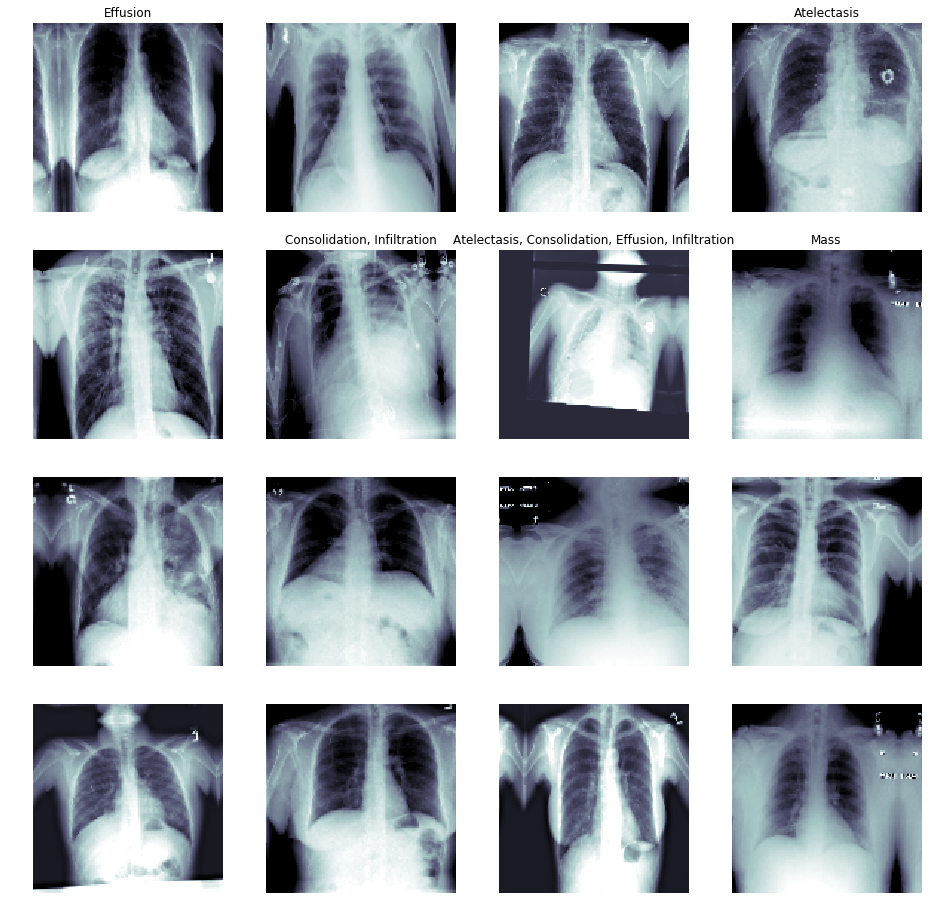

In [194]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

## 4. Create the Keras Deep Model with MobileNet

In [195]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.3))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.3))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 11)                5643      
Total params: 3,758,731
Trainable params: 3,736,843
Non-trainable params: 21,888
_____________________________________________________________

###  4.1 Create callbacks for after each epoch
We want to have certain callbacks after each epoch when training, such as saving the weights of our model and stoping early if after a certain number of epochs, we don't decrease our validation loss.

In [196]:
weight_path="weights.best.hdf5"
# multi_disease_model.load_weights(weight_path) # to load our previous weights, if needed/had
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)

callbacks_list = [checkpoint, early]

# Check Output
Here we see how many positive examples we have of each category

In [199]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 10.64%
Cardiomegaly: 3.12%
Consolidation: 4.20%
Edema: 2.64%
Effusion: 13.38%
Emphysema: 2.44%
Infiltration: 17.97%
Mass: 6.25%
Nodule: 4.59%
Pleural_Thickening: 3.61%
Pneumothorax: 4.88%


In [200]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 30s 30ms/step


# Continued Training
Now we do a much longer training process to see how the results improve

In [202]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list,
                                  use_multiprocessing = True)

Epoch 1/5
100/100 [==============================] - 344s 3s/step - loss: 0.2877 - binary_accuracy: 0.9297 - val_loss: 0.2635 - val_binary_accuracy: 0.9330

Epoch 00001: val_loss improved from 0.33993 to 0.26352, saving model to xray_class_weights.best.hdf5
Epoch 2/5
100/100 [==============================] - 339s 3s/step - loss: 0.2746 - binary_accuracy: 0.9291 - val_loss: 0.6103 - val_binary_accuracy: 0.9330

Epoch 00002: val_loss did not improve
Epoch 3/5
100/100 [==============================] - 343s 3s/step - loss: 0.2508 - binary_accuracy: 0.9268 - val_loss: 0.2597 - val_binary_accuracy: 0.9330

Epoch 00003: val_loss improved from 0.26352 to 0.25972, saving model to xray_class_weights.best.hdf5
Epoch 4/5
100/100 [==============================] - 331s 3s/step - loss: 0.2350 - binary_accuracy: 0.9310 - val_loss: 0.2377 - val_binary_accuracy: 0.9308

Epoch 00004: val_loss improved from 0.25972 to 0.23771, saving model to xray_class_weights.best.hdf5
Epoch 5/5
100/100 [============

In [203]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [204]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 26s 26ms/step


In [205]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 10.64%, PDx: 16.92%
Cardiomegaly: Dx: 3.12%, PDx: 1.73%
Consolidation: Dx: 4.20%, PDx: 7.41%
Edema: Dx: 2.64%, PDx: 3.74%
Effusion: Dx: 13.38%, PDx: 17.07%
Emphysema: Dx: 2.44%, PDx: 1.49%
Infiltration: Dx: 17.97%, PDx: 32.02%
Mass: Dx: 6.25%, PDx: 3.48%
Nodule: Dx: 4.59%, PDx: 3.68%
Pleural_Thickening: Dx: 3.61%, PDx: 1.24%
Pneumothorax: Dx: 4.88%, PDx: 2.35%


# Show a few images and associated predictions

## 5. Evaluating the Performance

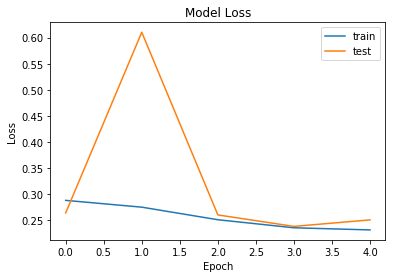

In [207]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The following allows us to visualize the different images that the model predicted as well as the percent confidence that our model though each was. As you can see, sometimes the model predicts it with low confidence but this is good enough vs how confident it was relative to the other finding labels

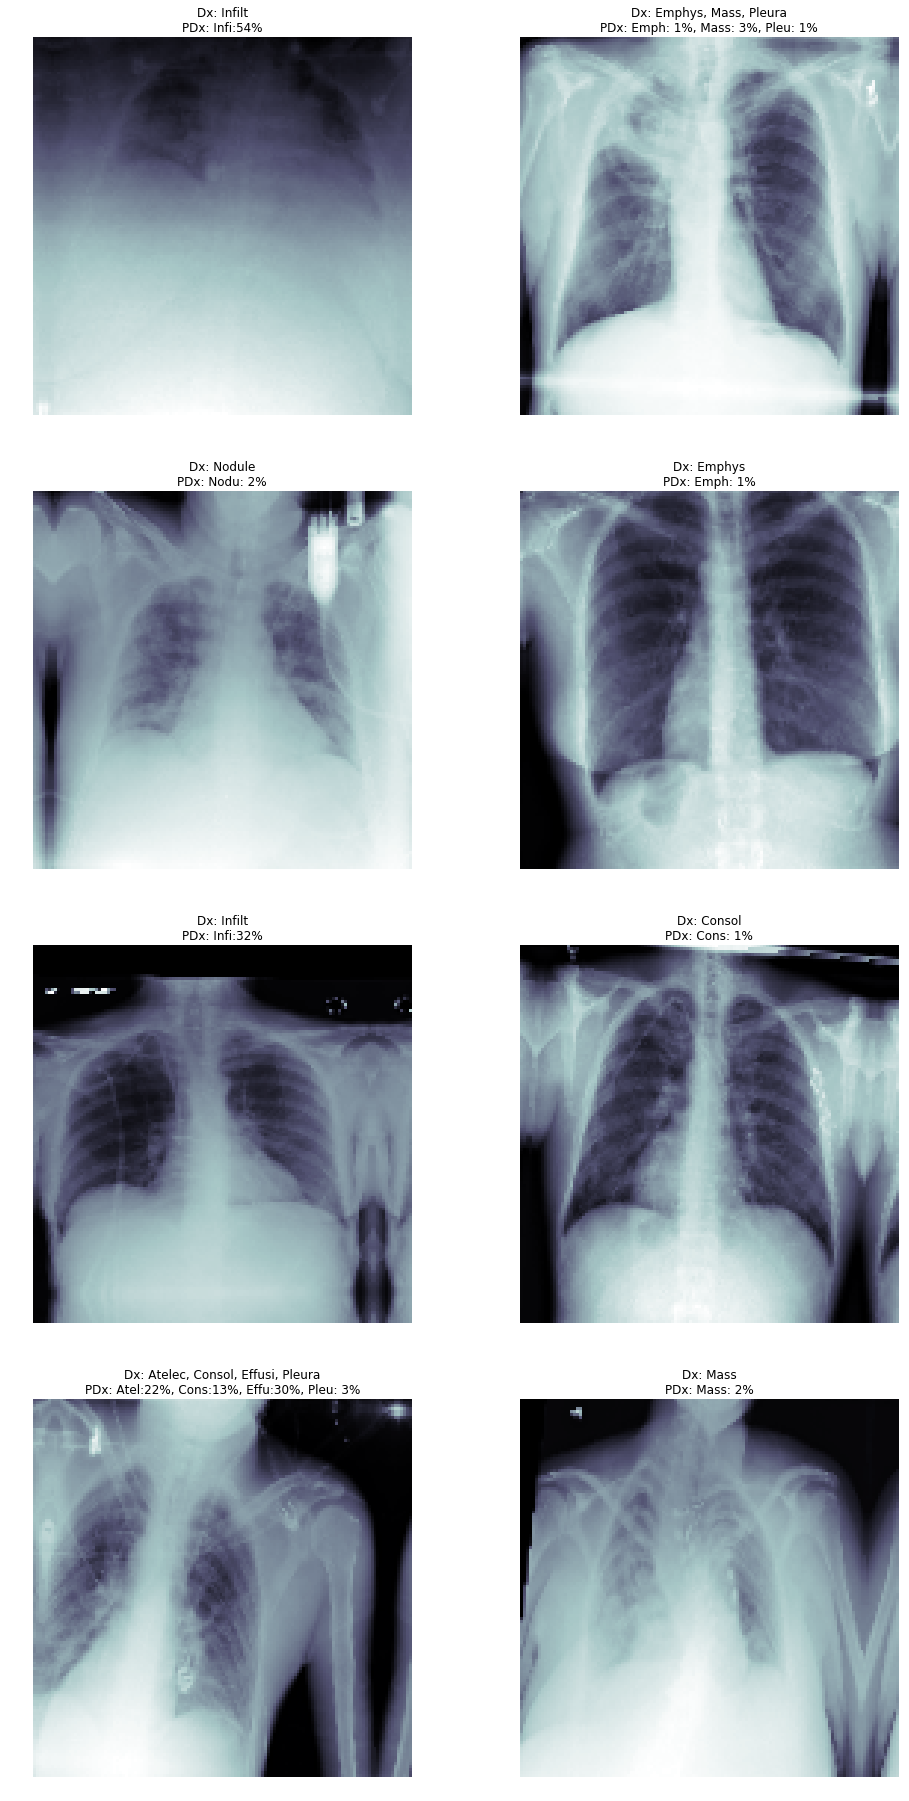

In [206]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

Overall, the performance looks promissing. We can see that the training data is decreasing in loss over every epoch and if time permitted, we could train this model to perform much better. 